In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_ = pd.read_csv(FILE_CHIK, index_col = 'Unnamed: 0' )
df_.index = pd.to_datetime(df_.index)
df_

,casos_2614857,casos_est_2614857,casos_est_min_2614857,casos_est_max_2614857,p_rt1_2614857,p_inc100k_2614857,temp_min_2614857,temp_max_2614857,umid_min_2614857,pressao_min_2614857,...,casos_2613800,casos_est_2613800,casos_est_min_2613800,casos_est_max_2613800,p_rt1_2613800,p_inc100k_2613800,temp_min_2613800,temp_max_2613800,umid_min_2613800,pressao_min_2613800
2010-01-03,0,0.0,0,0,0.0,0.0,21.666667,29.666667,54.333333,1010.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.0,0.0,22.000000,29.428571,53.142857,1010.714286,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.0,0.0,22.714286,29.857143,55.142857,1012.428571,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.0,0.0,21.142857,27.571429,62.142857,1011.285714,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.0,0.0,23.000000,30.000000,58.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-13,0,0.0,0,0,0.0,0.0,22.285714,28.428571,67.814565,1011.857143,...,1,1.0,1,2,0.226324,5.529444,21.285714,28.714286,56.140008,1012.714286
2022-11-20,0,0.0,0,0,0.0,0.0,22.000000,28.714286,65.847969,1012.428571,...,3,3.0,3,5,0.688444,16.588333,21.333333,27.833333,58.951291,1013.166667
2022-11-27,0,0.0,0,0,0.0,0.0,21.714286,28.142857,69.475706,1010.428571,...,3,3.0,3,6,0.699694,16.588333,20.000000,23.666667,78.238845,1012.333333
2022-12-04,0,0.0,0,0,0.0,0.0,22.857143,29.428571,61.823134,1008.142857,...,0,0.0,0,7,0.000000,0.000000,21.666667,27.000000,59.649207,1008.666667


Text(0.5, 1.0, 'Chik incidence')

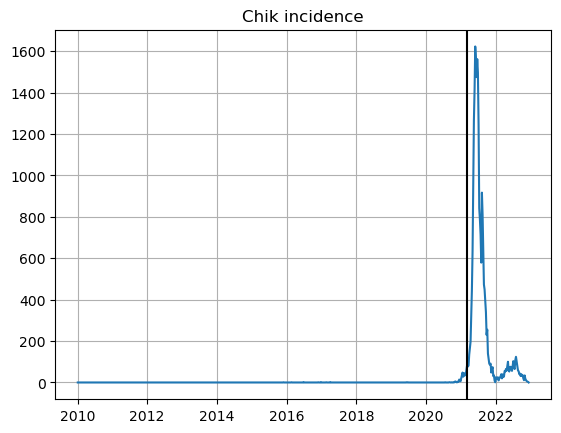

In [4]:
fig,ax = plt.subplots()
ax.plot(df_.casos_2611606)

ax.axvline(pd.to_datetime('2021-03-07'), color = 'black')

ax.grid()

ax.set_title('Chik incidence')

## Neural network model 

Parameters of the models:

In [5]:
END_DATE = '2021-04-18' # assign the last day used to evaluate the dengue model 

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 169 # number of features

Let's train the model with the loss function == msle 

Compilation Time :  0.0032472610473632812
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 169)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             11392     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
  

2023-03-11 19:30:07.946847: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


371/371 [==============================] - 3s 4ms/step - loss: 0.0150 - accuracy: 0.3154 - mape: 6255438.5000 - mse: 0.0265 - val_loss: 0.0148 - val_accuracy: 0.3333 - val_mape: 1584206.0000 - val_mse: 0.0296
Epoch 2/400
371/371 [==============================] - 1s 3ms/step - loss: 0.0061 - accuracy: 0.3181 - mape: 1399394.6250 - mse: 0.0119 - val_loss: 0.0075 - val_accuracy: 0.2727 - val_mape: 252181.8906 - val_mse: 0.0156
Epoch 3/400
371/371 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.2884 - mape: 1288652.1250 - mse: 0.0076 - val_loss: 0.0065 - val_accuracy: 0.3333 - val_mape: 609665.6875 - val_mse: 0.0128
Epoch 4/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0031 - accuracy: 0.2803 - mape: 1124156.2500 - mse: 0.0060 - val_loss: 0.0069 - val_accuracy: 0.4091 - val_mape: 713586.3125 - val_mse: 0.0146
Epoch 5/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0034 - accuracy: 0.2749 - mape: 1303139.5000 - mse: 0.

371/371 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.3612 - mape: 853342.9375 - mse: 0.0028 - val_loss: 0.0036 - val_accuracy: 0.3485 - val_mape: 301999.6562 - val_mse: 0.0076
Epoch 39/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.4043 - mape: 741499.6250 - mse: 0.0025 - val_loss: 0.0054 - val_accuracy: 0.3485 - val_mape: 779392.7500 - val_mse: 0.0108
Epoch 40/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.3908 - mape: 685603.3125 - mse: 0.0029 - val_loss: 0.0040 - val_accuracy: 0.4394 - val_mape: 1042969.0625 - val_mse: 0.0083
Epoch 41/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.3881 - mape: 543708.5625 - mse: 0.0021 - val_loss: 0.0042 - val_accuracy: 0.3788 - val_mape: 520641.2188 - val_mse: 0.0088
Epoch 42/400
371/371 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.4097 - mape: 789588.6250 - mse: 0.0

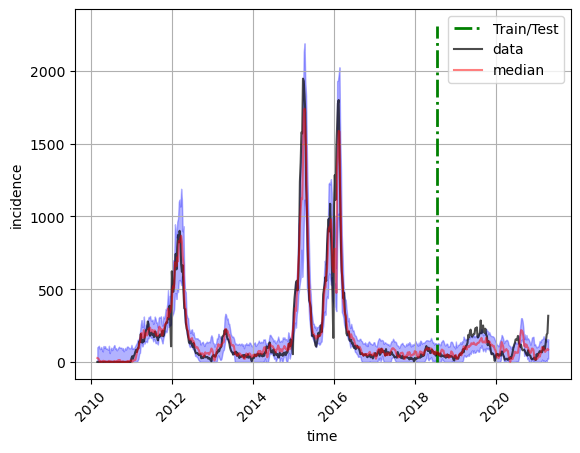

CPU times: user 4min 29s, sys: 15.8 s, total: 4min 45s
Wall time: 4min 8s


In [6]:
%%time

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

metrics_msle, hist_msle, m_train, m_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle', filename = FILENAME_DATA)

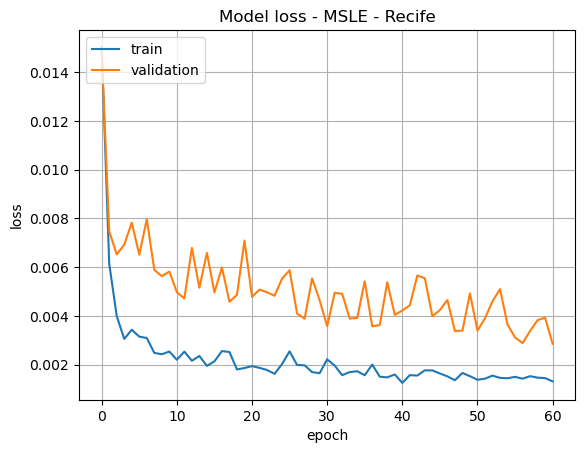

In [7]:
plot_loss(hist_msle, title = 'Model loss - MSLE - Recife')

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.00278472900390625
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 169)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             11392     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
  

493/493 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.3225 - mape: 526248.1250 - mse: 0.0034 - val_loss: 0.0022 - val_accuracy: 0.2841 - val_mape: 644511.1250 - val_mse: 0.0046
Epoch 32/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.3712 - mape: 620548.6875 - mse: 0.0027 - val_loss: 0.0025 - val_accuracy: 0.3068 - val_mape: 278212.0312 - val_mse: 0.0051
Epoch 33/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.3834 - mape: 447299.5938 - mse: 0.0025 - val_loss: 0.0022 - val_accuracy: 0.2273 - val_mape: 541491.0625 - val_mse: 0.0042
Epoch 34/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.3428 - mape: 618615.6250 - mse: 0.0025 - val_loss: 0.0018 - val_accuracy: 0.3523 - val_mape: 748255.8125 - val_mse: 0.0033
Epoch 35/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.3469 - mape: 574307.5625 - mse: 0.00

493/493 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.3854 - mape: 519981.7500 - mse: 0.0022 - val_loss: 0.0013 - val_accuracy: 0.3523 - val_mape: 279684.5312 - val_mse: 0.0023
Epoch 69/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.3874 - mape: 399460.8750 - mse: 0.0022 - val_loss: 0.0013 - val_accuracy: 0.3636 - val_mape: 53.1013 - val_mse: 0.0024
Epoch 70/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.3671 - mape: 546050.4375 - mse: 0.0022 - val_loss: 0.0015 - val_accuracy: 0.3523 - val_mape: 60.8515 - val_mse: 0.0026
Epoch 71/400
493/493 [==============================] - 3s 5ms/step - loss: 0.0013 - accuracy: 0.3976 - mape: 490273.8438 - mse: 0.0026 - val_loss: 0.0016 - val_accuracy: 0.3523 - val_mape: 156282.0625 - val_mse: 0.0031
Epoch 72/400
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.4077 - mape: 449163.9375 - mse: 0.0024 - val

493/493 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.3874 - mape: 154455.1094 - mse: 0.0019 - val_loss: 0.0015 - val_accuracy: 0.3977 - val_mape: 35192.1328 - val_mse: 0.0028
Epoch 106/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.3753 - mape: 401839.4688 - mse: 0.0024 - val_loss: 0.0014 - val_accuracy: 0.3409 - val_mape: 210106.6094 - val_mse: 0.0028
Epoch 107/400
493/493 [==============================] - 2s 5ms/step - loss: 9.5969e-04 - accuracy: 0.3834 - mape: 244132.4844 - mse: 0.0018 - val_loss: 0.0016 - val_accuracy: 0.3182 - val_mape: 487.3477 - val_mse: 0.0033
Epoch 108/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.3935 - mape: 317354.6875 - mse: 0.0024 - val_loss: 0.0015 - val_accuracy: 0.3523 - val_mape: 51.0466 - val_mse: 0.0032
Epoch 109/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.3671 - mape: 401922.8750 - mse: 0.00

493/493 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.3935 - mape: 319599.6250 - mse: 0.0020 - val_loss: 0.0012 - val_accuracy: 0.3523 - val_mape: 289681.3438 - val_mse: 0.0022
Epoch 143/400
493/493 [==============================] - 2s 4ms/step - loss: 0.0010 - accuracy: 0.3996 - mape: 423750.0312 - mse: 0.0021 - val_loss: 0.0015 - val_accuracy: 0.2955 - val_mape: 56.2938 - val_mse: 0.0028
Epoch 144/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.3732 - mape: 316037.5625 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.3295 - val_mape: 725187.8750 - val_mse: 0.0027
Epoch 145/400
493/493 [==============================] - 2s 5ms/step - loss: 9.3225e-04 - accuracy: 0.4118 - mape: 285120.3750 - mse: 0.0018 - val_loss: 0.0016 - val_accuracy: 0.3636 - val_mape: 381248.9688 - val_mse: 0.0031
Epoch 146/400
493/493 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.3935 - mape: 548583.3125 - mse: 

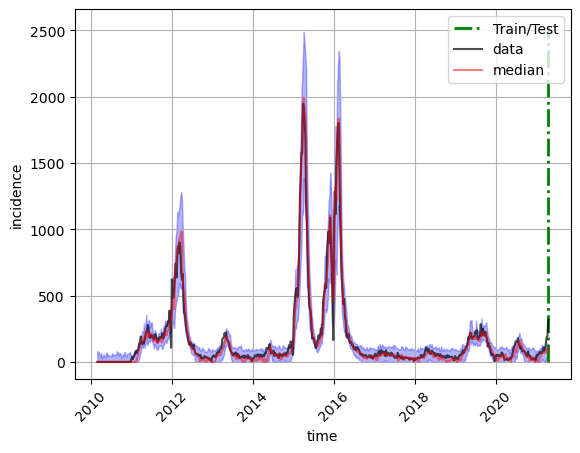

In [8]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 309.5693
Estimator 1/100, Train metric: 282.5878
Estimator 2/100, Train metric: 258.1819
Estimator 3/100, Train metric: 235.9561
Estimator 4/100, Train metric: 215.9624
Estimator 5/100, Train metric: 197.8378
Estimator 6/100, Train metric: 181.2329
Estimator 7/100, Train metric: 166.1838
Estimator 8/100, Train metric: 152.3144
Estimator 9/100, Train metric: 139.7594
Estimator 10/100, Train metric: 128.3571
Estimator 11/100, Train metric: 117.9146
Estimator 12/100, Train metric: 108.3470
Estimator 13/100, Train metric: 99.5644
Estimator 14/100, Train metric: 91.5327
Estimator 15/100, Train metric: 84.2457
Estimator 16/100, Train metric: 77.6504
Estimator 17/100, Train metric: 71.5092
Estimator 18/100, Train metric: 65.9535
Estimator 19/100, Train metric: 60.7224
Estimator 20/100, Train metric: 56.1449
Estimator 21/100, Train metric: 51.8181
Estimator 22/100, Train metric: 47.8518
Estimator 23/100, Train metric: 44.3072
Estimator 24/100, Train metric: 41.04

Estimator 8/100, Train metric: 157.6739
Estimator 9/100, Train metric: 145.5002
Estimator 10/100, Train metric: 134.3323
Estimator 11/100, Train metric: 124.2633
Estimator 12/100, Train metric: 114.7309
Estimator 13/100, Train metric: 106.1685
Estimator 14/100, Train metric: 98.5087
Estimator 15/100, Train metric: 91.4213
Estimator 16/100, Train metric: 84.4642
Estimator 17/100, Train metric: 78.7161
Estimator 18/100, Train metric: 72.9169
Estimator 19/100, Train metric: 67.6892
Estimator 20/100, Train metric: 62.9477
Estimator 21/100, Train metric: 58.6644
Estimator 22/100, Train metric: 54.7661
Estimator 23/100, Train metric: 51.2875
Estimator 24/100, Train metric: 48.0965
Estimator 25/100, Train metric: 45.2225
Estimator 26/100, Train metric: 42.2971
Estimator 27/100, Train metric: 39.6609
Estimator 28/100, Train metric: 37.1380
Estimator 29/100, Train metric: 34.8423
Estimator 30/100, Train metric: 32.7486
Estimator 31/100, Train metric: 30.5974
Estimator 32/100, Train metric: 28.9

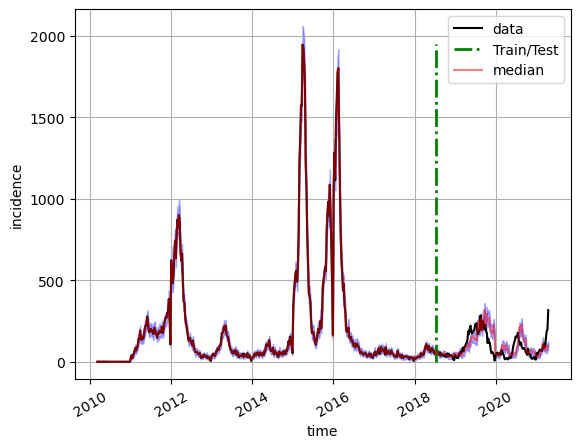

In [9]:

preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE, label = 'train_test',  filename = FILENAME_DATA)

Estimator 0/100, Train metric: 273.8131
Estimator 1/100, Train metric: 249.9845
Estimator 2/100, Train metric: 228.4628
Estimator 3/100, Train metric: 208.7785
Estimator 4/100, Train metric: 191.0114
Estimator 5/100, Train metric: 174.9662
Estimator 6/100, Train metric: 160.4146
Estimator 7/100, Train metric: 146.9896
Estimator 8/100, Train metric: 134.7826
Estimator 9/100, Train metric: 123.7140
Estimator 10/100, Train metric: 113.6324
Estimator 11/100, Train metric: 104.4378
Estimator 12/100, Train metric: 96.1084
Estimator 13/100, Train metric: 88.5176
Estimator 14/100, Train metric: 81.4793
Estimator 15/100, Train metric: 74.8825
Estimator 16/100, Train metric: 68.8826
Estimator 17/100, Train metric: 63.4249
Estimator 18/100, Train metric: 58.4801
Estimator 19/100, Train metric: 54.1354
Estimator 20/100, Train metric: 50.0820
Estimator 21/100, Train metric: 46.4075
Estimator 22/100, Train metric: 42.9283
Estimator 23/100, Train metric: 39.9250
Estimator 24/100, Train metric: 37.163

Estimator 8/100, Train metric: 140.2218
Estimator 9/100, Train metric: 129.4551
Estimator 10/100, Train metric: 119.5593
Estimator 11/100, Train metric: 110.6548
Estimator 12/100, Train metric: 102.4836
Estimator 13/100, Train metric: 95.1682
Estimator 14/100, Train metric: 88.2433
Estimator 15/100, Train metric: 82.1796
Estimator 16/100, Train metric: 76.4105
Estimator 17/100, Train metric: 71.0622
Estimator 18/100, Train metric: 66.1679
Estimator 19/100, Train metric: 61.7189
Estimator 20/100, Train metric: 57.6527
Estimator 21/100, Train metric: 53.9626
Estimator 22/100, Train metric: 50.6120
Estimator 23/100, Train metric: 47.4847
Estimator 24/100, Train metric: 44.6338
Estimator 25/100, Train metric: 41.8001
Estimator 26/100, Train metric: 39.2465
Estimator 27/100, Train metric: 36.9401
Estimator 28/100, Train metric: 34.7195
Estimator 29/100, Train metric: 32.4906
Estimator 30/100, Train metric: 30.4657
Estimator 31/100, Train metric: 28.6129
Estimator 32/100, Train metric: 27.12

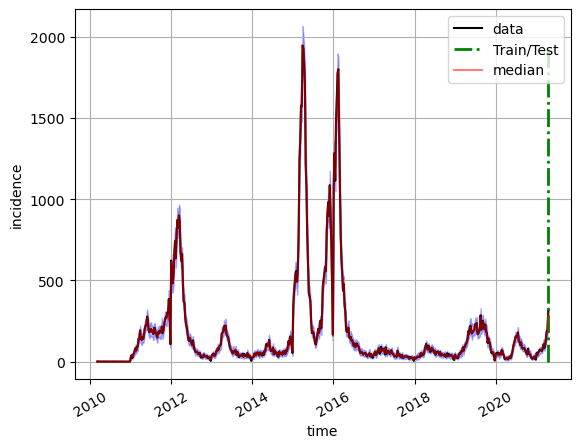

In [10]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   